In [142]:
import pandas as pd                     # dataframe functionality
import geopandas as gpd                 # geodataframe functionality
from shapely.geometry import Point      # for buffer analysis
import matplotlib.pyplot as plt         # mapping
import pytidycensus as tc               # census api helper


In [143]:
'''
Get Borough Boundaries (API)
'''
borough_url = "https://data.cityofnewyork.us/resource/gthc-hcne.geojson" # ABOUT: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/gthc-hcne/about_data
borough_gdf = gpd.read_file(borough_url)

# Create new geodataframe using filter
bk_qn_gdf = borough_gdf[(borough_gdf["boroname"]=="Brooklyn") | (borough_gdf["boroname"]=="Queens")]    # Brooklyn and queens borough boundaries


In [144]:
'''
Get IBX ROW & Stations (local file)
'''
ibx_path = r"C:\Users\orinj\Documents\Urban Planning\GIS Data\IBX\IBX.gdb"

# Find layers in geodatabase file
layers = gpd.list_layers(ibx_path)
layer_names = layers['name'].to_list()

# Store each layer as a geodataframe in a dictionary with index as name
geodataframes = {}
for name in layer_names:
    geodataframes[name] = gpd.read_file(ibx_path, layer=name)

# Save each layer as a named geodataframe
ibx_gdf = geodataframes['IBX_Rail_Line']
stations_gdf = geodataframes['stations']

## How to find new census variables
1. Go to this site to find census API variable codes: https://api.census.gov/data.html
2. Search for "ACS 5-Year Detailed Tables"
3. Select the one you want
4. Search for key words (using Census Reporter or other search engines can be helpful to find keywords)
5. Find the variable you want
6. _001E is the top level total estimate for each variable - choose the relevant row (again helpful to visualize table rows in Census Reporter)

For example: https://api.census.gov/data/2023/acs/acs5/variables.html

You may need the top level estimate _001E (example: total households) and the row level estimate (example: households with x) which might be _007E, the seventh row of data. With these two variables, you can calculate a percent (households with x / total households * 100)

In [145]:
'''
Get block group data (API)
'''

# Set census API key
tc.set_census_api_key("2860f2844d671bd10d3eceb44c50bb4da851972a")

bg_census_vars = [
"B19013_001E",          # Median household income
"B08301_001E",          # Means of transportation to work: Total estimates (age 16+)
"B08301_002E",          # Means of transportation to work: Car, truck, or van (age 16+)
"B08201_002E",          # Percent of households with no car (inverse is percent with one or more car)

"B15003_001E",          # Educational attainment: total population (25+)
"B15003_022E",          # Educational attainment: total bachelor's degree (25+)
]

counties = ["Kings", "Queens"]

# Get ACS data
bgs_acs_gdf = tc.get_acs(
    variables=bg_census_vars,
    geography="block group",    # Set census data area
    state="NY",
    county=counties,
    year=2023,
    output="wide",
    geometry=True  # Get geometry
)


'''
Get census tract data (API)
'''
tract_census_vars = [
"B08201_001E",          # Number of households (from car ownership table)
"B08201_002E",          # Number of households with no car (inverse is percent with one or more car)
]

counties = ["Kings", "Queens"]

# Get ACS data
tracts_acs_gdf = tc.get_acs(
    variables=tract_census_vars,
    geography="tract",    # Set census data area
    state="NY",
    county=counties,
    year=2023,
    output="wide",
    geometry=True  # Get geometry
)

Census API key has been set for this session.
Getting data from the 2019-2023 5-year ACS
Getting data from the 2019-2023 5-year ACS


In [146]:
'''
Reproject CRS
'''
# reproject to projected CRS local to NY
bk_qn_gdf_2263 = bk_qn_gdf.to_crs(epsg=2263)  # NY State Plane (feet)
ibx_gdf_2263 = ibx_gdf.to_crs(epsg=2263)
stations_gdf_2263 = stations_gdf.to_crs(epsg=2263)

bgs_acs_gdf_2263 = bgs_acs_gdf.to_crs(epsg=2263)  # NY State Plane (feet)
tracts_acs_gdf_2263 = tracts_acs_gdf.to_crs(epsg=2263)  # NY State Plane (feet)

In [147]:
'''
Create buffers and filter data

- half mile walkshed radius (buffers)
- include all block groups with centroid within radius/buffer

'''

# Create station buffers
buffer_radius = 5280*.5  # half mile radius
stations_gdf_2263['buffer'] = stations_gdf_2263.geometry.buffer(buffer_radius)  # add buffer column with data for each station

# combine buffers into one geometry
# Note: this prevents counting areas more than once with overlapping buffers
from shapely.ops import unary_union
all_buffers = unary_union(stations_gdf_2263['buffer'])

# Add centroid data to block groups
bgs_acs_gdf_2263['centroid'] = bgs_acs_gdf_2263.geometry.centroid
tracts_acs_gdf_2263['centroid'] = tracts_acs_gdf_2263.geometry.centroid

# Find areas with centroid within buffer radius
ibx_walkshed_bgs = bgs_acs_gdf_2263[bgs_acs_gdf_2263['centroid'].within(all_buffers)]   # block groups
ibx_walkshed_tracts = tracts_acs_gdf_2263[tracts_acs_gdf_2263['centroid'].within(all_buffers)]   # tracts

In [148]:
'''
Add analysis columns/fields

Block Groups
- percent_car_commute
- mhi

Tracts
- percent_car_own

'''

# block groups
ibx_walkshed_bgs['percent_car_commute'] = (ibx_walkshed_bgs['B08301_002E'] / ibx_walkshed_bgs['B08301_001E'] * 100).round()
ibx_walkshed_bgs["mhi"] = ibx_walkshed_bgs["B19013_001E"].round()
ibx_walkshed_bgs['percent_bachelors'] = (ibx_walkshed_bgs['B15003_022E'] / ibx_walkshed_bgs['B15003_001E'] * 100).round()

print('Number of census block groups included:', len(ibx_walkshed_bgs))

# tracts
ibx_walkshed_tracts['percent_car_own'] = (100 - ibx_walkshed_tracts['B08201_002E'] / ibx_walkshed_tracts['B08201_001E'] * 100).round()  # get 'inverse' of percentage

print('Number of census tracts included:', len(ibx_walkshed_tracts))


Number of census block groups included: 384
Number of census tracts included: 154


c:\Users\orinj\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\orinj\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\orinj\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is tryin

In [149]:
'''
Associating stations with block groups and census tracts
'''
# Create gdf for just centroids (block groups and tracts)
block_group_centroids = ibx_walkshed_bgs.copy()
tract_centroids = ibx_walkshed_tracts.copy()
# Rewrite geometry column to contain centroid data for each geography
block_group_centroids['geometry'] = block_group_centroids.geometry.centroid
tract_centroids['geometry'] = tract_centroids.geometry.centroid

# Spatial join: assigns each block centroid to the nearest station
bg_nearest_join = gpd.sjoin_nearest(
    left_df=block_group_centroids,      # left GeoDataFrame (the centroids)
    right_df=stations_gdf_2263,          # right GeoDataFrame (stations)
    how='left',            # keep all blocks even if no station found
)

tract_nearest_join = gpd.sjoin_nearest(
    left_df=tract_centroids,
    right_df=stations_gdf_2263,
    how='left',
)


# Keep only necessary columns
bg_nearest_join = bg_nearest_join[['GEOID', 'station', 'geometry']]
tract_nearest_join = tract_nearest_join[['GEOID', 'station', 'geometry']]

# Merge back with original geodataframe
ibx_walkshed_bgs = ibx_walkshed_bgs.merge(
    bg_nearest_join[['GEOID', 'station']],
    on='GEOID',
    how='left'
)

ibx_walkshed_tracts = ibx_walkshed_tracts.merge(
    tract_nearest_join[['GEOID', 'station']],
    on='GEOID',
    how='left'
)


In [150]:
''' 
Aggregate block group and tract data by station
'''

# temporary subset of working gdf - not all data needed for tabular output
temp_bg_agg_by_station = ibx_walkshed_bgs[['percent_car_commute', 'mhi', 'station', 'percent_bachelors']]
temp_tract_agg_by_station = ibx_walkshed_tracts[['percent_car_own', 'station']]


# Define variables, grouping, and method of aggregation
bg_agg_by_station = temp_bg_agg_by_station.groupby("station").agg(
    {
        'percent_car_commute': 'mean',
        'mhi': 'mean',
        'percent_bachelors': 'mean',
    }
).reset_index()     # recreates gdf


# Define variables, grouping, and method of aggregation
tract_agg_by_station = temp_tract_agg_by_station.groupby("station").agg(
    {
        'percent_car_own': 'mean',
    }
).reset_index()     # recreates gdf

# Start aggregated stations as gdf built from station data
stations_base = stations_gdf_2263[['object_id', 'geometry', 'station']]


stations_w_bg = stations_base.merge(
    bg_agg_by_station[['station','percent_car_commute', 'mhi', 'percent_bachelors']],
    on="station",
    how="left"
)

stations_aggregated = stations_w_bg.merge(
    tract_agg_by_station[['station','percent_car_own']],
    on="station",
    how="left"
)

# Set column order
stations_aggregated = stations_aggregated[['object_id','geometry','station','mhi','percent_car_own','percent_car_commute','percent_bachelors']]

# Round and convert datatypes as needed
stations_aggregated['mhi'] = pd.to_numeric(stations_aggregated['mhi'], errors='coerce').round() # requires converting from object type to numeric for some reason
stations_aggregated['percent_car_commute'] = stations_aggregated['percent_car_commute'].round()
stations_aggregated['percent_car_own'] = stations_aggregated['percent_car_own'].round()
stations_aggregated['percent_bachelors'] = stations_aggregated['percent_bachelors'].round()






In [151]:
''' 
Output tabular data
'''
# quick table view package
from itables import show # pip install typing_extensions, itables


show(stations_aggregated)

Loading ITables v2.5.2 from the internet... (need help?)


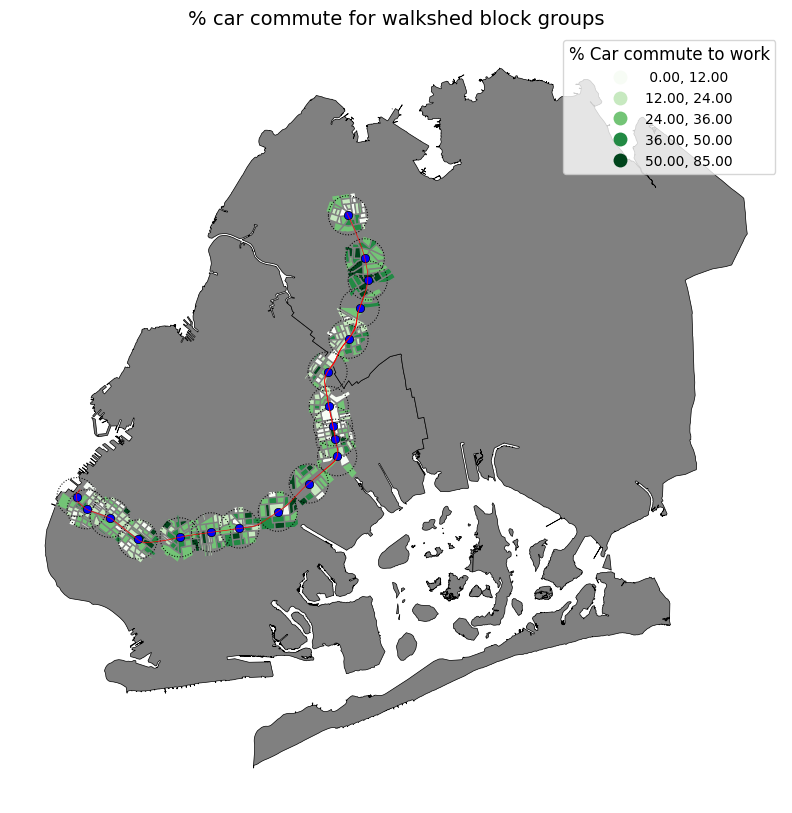

In [152]:
''' 
Plot % car commute for walkshed block groups
'''
# Set up plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot geodataframes
bk_qn_gdf_2263.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.5)
ibx_walkshed_bgs.plot(
    ax=ax,
    column="percent_car_commute",
    cmap="Greens",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="grey",
    legend=True,
    # categorical=True,
    legend_kwds={
        "title": "% Car commute to work",
        "loc": "upper right",
        "fontsize": 10,
        "title_fontsize": 12
    }
)
ibx_gdf_2263.plot(ax=ax, color="red", edgecolor="black", linewidth=0.5)
stations_gdf_2263['buffer'].plot(ax=ax, color="none", edgecolor="black", linewidth=.75, linestyle=':')
stations_gdf_2263.plot(ax=ax, color="blue", edgecolor="black", linewidth=0.5)

ax.set_title("% car commute for walkshed block groups", fontsize=14)
ax.set_axis_off()   # remove axes
plt.show()


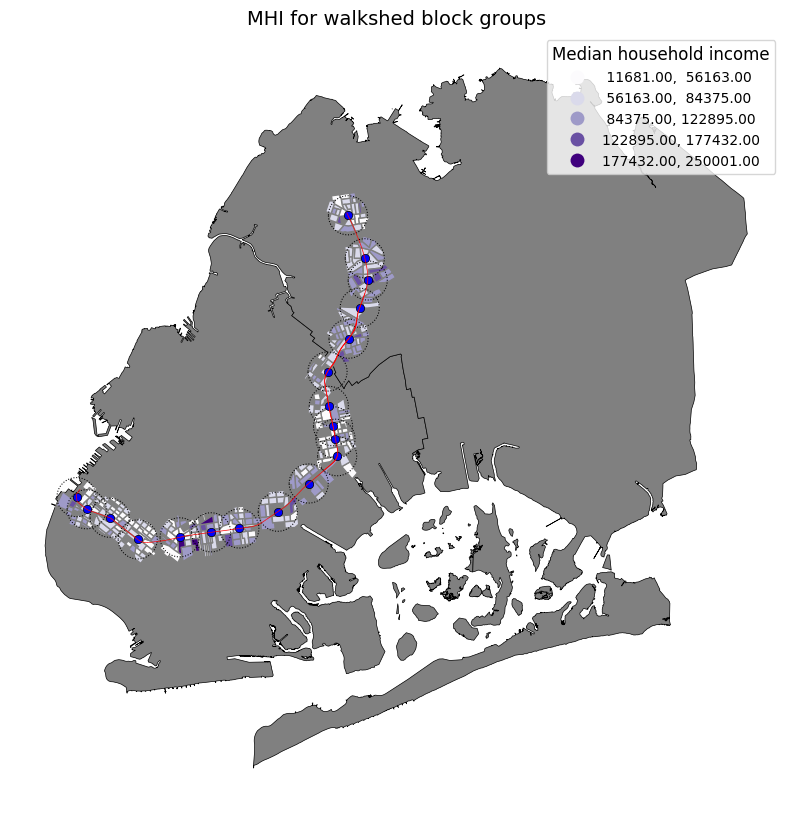

In [153]:
''' 
Plot MHI for walkshed block groups
'''
# Set up plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot geodataframes
bk_qn_gdf_2263.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.5)
ibx_walkshed_bgs.plot(
    ax=ax,
    column="mhi",
    cmap="Purples",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="grey",
    legend=True,
    # categorical=True,
    legend_kwds={
        "title": "Median household income",
        "loc": "upper right",
        "fontsize": 10,
        "title_fontsize": 12
    }
)
ibx_gdf_2263.plot(ax=ax, color="red", edgecolor="black", linewidth=0.5)
stations_gdf_2263['buffer'].plot(ax=ax, color="none", edgecolor="black", linewidth=.75, linestyle=':')
stations_gdf_2263.plot(ax=ax, color="blue", edgecolor="black", linewidth=0.5)

ax.set_title("MHI for walkshed block groups", fontsize=14)
ax.set_axis_off()   # remove axes
plt.show()
